# 랜덤 포레스트 사용하기

In [11]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [12]:
train = pd.read_csv('bike_data/train.csv', parse_dates=['datetime'])
test = pd.read_csv('bike_data/test.csv', parse_dates=['datetime'])
print(train.shape)
print(test.shape)

(10886, 12)
(6493, 9)


### Feature Engineering

In [13]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 19)

In [14]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 16)

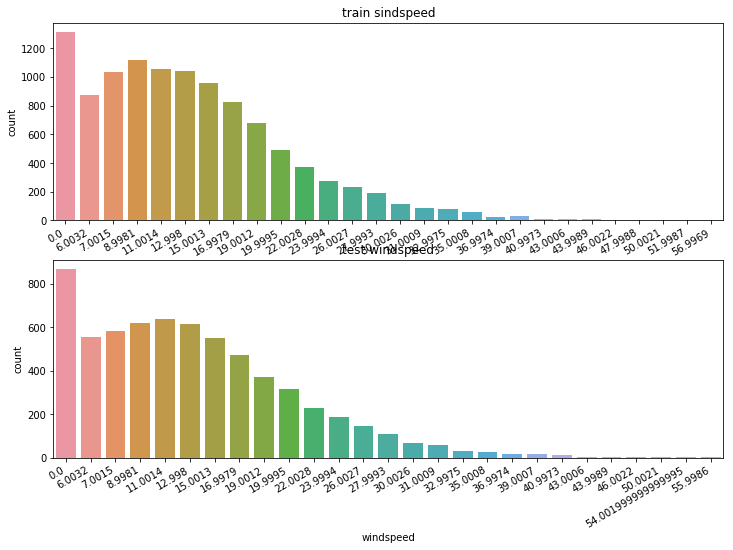

In [15]:
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(12,8)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count', title='train sindspeed')
sns.countplot(data=train, x='windspeed', ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count',title="test windspeed")
sns.countplot(data=test, x="windspeed", ax=axes[1])

### 풍속에 0이 많아 고칠 필요가 있다
### 그래서 랜덤포레스트로 예측할 것이다

In [16]:
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    
    # 풍속 0 / 0 아닌 것
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    # 풍속 예측할 feature 선택
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]
    
    # v풍속 0이 아닌 데이터 타입을 str로 바꾼다
    dataWindNot0['windspeed'] = dataWindNot0['windspeed'].astype('str')
    
    # 랜덤 포레스트 분류기 사용
    rfModel_wind = RandomForestClassifier()
    
    # wCol의 feature 값을 바탕으로 풍속 학습
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0['windspeed'])
    
    # 학습한 값을 바탕으로 풍속 0의 풍속을 예측
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])
    
    # 예측 후 비교하기 위해 예측값 넣을 데이터 프레임 새로 만듦
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0
    
    # 풍속 0인 것에 예측값을 넣는다
    predictWind0['windspeed'] = wind0Values
    
    # 0이 아닌 풍속 데이터 프레임과 합쳐준다
    data = predictWindNot0.append(predictWind0)
    
    # 풍속 데이터 타입을 float으로 지정
    data['windspeed'] = data['windspeed'].astype('float')
    
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

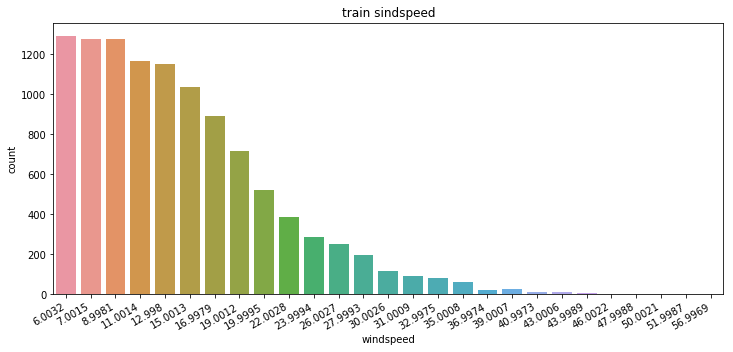

In [17]:
# 0값 조정
train = predict_windspeed(train)

# 풍속 조정한 것을 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(12,5)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count', title='train sindspeed')
sns.countplot(data=train, x='windspeed', ax=ax1)

# Feature Selection
- 신호와 잡음을 구분
- Feature가 많다고 좋지는 않다 (오버피팅 가능성)
- 성능이 좋지 않은 feature는 제거한다

In [18]:
# 연속형 feature와 범주형 feature 
# 연속형 feature = ["temp","humidity","windspeed","atemp"]
# 범주형 feature의 type을 category로 변경해 준다.
# 범주형 자료는 one-hot encoding을 사용하기도 한다
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [19]:
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed",
                 "year", "hour", "dayofweek", "holiday", "workingday"]

In [21]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [22]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [23]:
label_name = 'count'
y_train = train[label_name]
print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

### RMSLE 사용

In [24]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)

    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)

    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)

    # 평균을 낸다.
    mean_difference = difference.mean()

    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)

    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

### 교차 검증

In [25]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

### 랜덤 포레스트

In [26]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []
model = RandomForestRegressor(n_estimators=100,
                             n_jobs=-1,
                             random_state=0)
model

# n_estimators가 크면 정확도가 올라가는 편

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [27]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)

score = score.mean()
print('Score = {0:.5f}'.format(score))

Wall time: 7.3 s
Score = 0.33119


### Train
- feature와 label을 넣어주면 알아서 학습

In [28]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [29]:
# 예측
predictions = model.predict(X_test)

print(predictions.shape)
predictions[:10]

(6493,)


array([ 12.35,   5.16,   4.22,   3.5 ,   3.12,   6.17,  38.46, 105.24,
       236.72, 136.5 ])

[Text(0.5, 1.0, 'Prediction')]

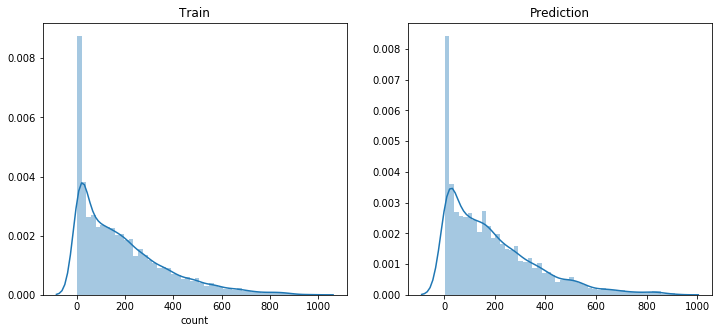

In [30]:
# 예측한 데이터 시각화
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)

sns.distplot(y_train, ax=ax1, bins=50)
ax1.set(title='Train')
sns.distplot(predictions, ax=ax2, bins=50)
ax2.set(title='Prediction')

### Submit
- 캐글에 제출

In [31]:
submission = pd.read_csv("bike_data/sampleSubmission.csv")
submission

submission["count"] = predictions

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.35
1,2011-01-20 01:00:00,5.16
2,2011-01-20 02:00:00,4.22
3,2011-01-20 03:00:00,3.50
4,2011-01-20 04:00:00,3.12


In [32]:
submission.to_csv("bike_data/Score_{0:.5f}_submission.csv".format(score), index=False)